In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create a project folder in Drive
project_path = '/content/drive/MyDrive/Malaria_Cell_Classifier'
import os
os.makedirs(project_path, exist_ok=True)
print(" Project folder created at:", project_path)

 Project folder created at: /content/drive/MyDrive/Malaria_Cell_Classifier


In [6]:
!pip install -q plotly scikit-learn pandas seaborn umap-learn

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
import os
print(os.listdir('/content/drive/MyDrive/'))

['Screenshot_20250415_121213_Doc Scanner.jpg', 'Method of Induction and Binomial Theorem.pdf', 'probability  thoerm (1).pdf', 'paid .jpg', 'Amount payment.jpg', 'CourseGuideline_SummerSchool2021.pdf', 'Chemistry Formula.pdf', 'Mathematics Formula.pdf', 'Physics formula for Add.pdf', 'Ayesha Arif Khan', 'Certificate of iirs.pdf', 'What Next.pdf', 'Physics-Practical-viva-1.pdf', 'ConfirmationPage-220310675259.pdf', 'Chemistry Formula Booklet.pdf', 'physics shortcuts.pdf', 'Official Documents ', 'Xerox documents ', 'Less than 300 kb (original )', 'Classroom', 'EM FORMULAS.pdf', 'DOC-20221109-WA0000..gdoc', 'FE', 'Cyber Safety Awareness Campaign Certificate.pdf', 'Superconductors and supercapacitor 07-28-2020 13.40.05 (1).gdoc', 'BEE QB 2.gdoc', 'Mechanics QB (AIML D 17) (1).pdf', 'Mechanics QB (AIML D 17).pdf', 'Physics techmax.pdf', 'Communication Skills  Chapter I - FINAL (1) (1) (1).gslides', 'distinguish between.docx.gdoc', 'DRESSING AND GROOMING.gslides', 'ETIQUETTES.gslides', 'Commu

In [9]:
import os
folder_path = '/content/drive/MyDrive/cell_images' # Replace with the actual path to your folder
print(os.listdir(folder_path))

['Uninfected', 'cell_images', 'Parasitized']


Attempting to load image: /content/drive/MyDrive/cell_images/Parasitized/C116P77ThinF_IMG_20150930_171844_cell_118.png
Attempting to load image: /content/drive/MyDrive/cell_images/Uninfected/Thumbs.db
Error: Could not load image from /content/drive/MyDrive/cell_images/Uninfected/Thumbs.db


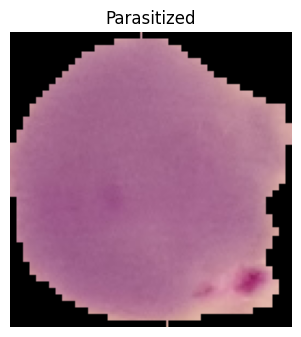

In [29]:
# Step 5: Visualize sample images
import matplotlib.pyplot as plt
import cv2, random
import os

data_dir = '/content/drive/MyDrive/cell_images' # Define data_dir

parasitized_path = os.path.join(data_dir, "Parasitized")
uninfected_path = os.path.join(data_dir, "Uninfected")

# Check if directories exist
if not os.path.exists(parasitized_path):
    print(f"Error: Directory not found at {parasitized_path}")
elif not os.path.exists(uninfected_path):
    print(f"Error: Directory not found at {uninfected_path}")
else:
    sample_images = []
    # Add a check to ensure the directory is not empty
    if os.listdir(parasitized_path):
        sample_images.append(os.path.join(parasitized_path, random.choice(os.listdir(parasitized_path))))
    else:
        print(f"Warning: Parasitized directory is empty at {parasitized_path}")

    if os.listdir(uninfected_path):
        sample_images.append(os.path.join(uninfected_path, random.choice(os.listdir(uninfected_path))))
    else:
        print(f"Warning: Uninfected directory is empty at {uninfected_path}")

    if sample_images:
        plt.figure(figsize=(8,4))
        for i, img_path in enumerate(sample_images):
            print(f"Attempting to load image: {img_path}") # Print the image path
            img = cv2.imread(img_path)

            if img is None: # Check if image loading failed
                print(f"Error: Could not load image from {img_path}")
                continue # Skip to the next image if loading fails

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1,2,i+1)
            plt.imshow(img)
            plt.title("Parasitized" if "Parasitized" in img_path else "Uninfected")
            plt.axis("off")
        plt.show()
    else:
        print("No sample images to display.")

In [20]:
# Step 6: Create training and validation datasets
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

class_names = train_ds.class_names
print("Class Names:", class_names)


Found 3286 files belonging to 3 classes.
Using 2629 files for training.
Found 3286 files belonging to 3 classes.
Using 657 files for validation.
Class Names: ['Parasitized', 'Uninfected', 'cell_images']


In [21]:
# Step 7: Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [22]:
# Step 8: Build and compile EfficientNet model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [23]:
# Step 9: Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - accuracy: 0.9572 - loss: 0.1580 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 7.9439e-04
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 5.3321e-04
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 1.0000 - loss: 7.9007e-04 - val_accuracy: 1.0000 - val_loss: 3.8252e-04
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 1.0000 - loss: 6.1685e-04 - val_accuracy: 1.0000 - val_loss: 2.9026e-04
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 1.0000 - loss: 4.3991e-04 - val_accuracy: 1.0000 - val_loss: 2.2940e-04
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 1.0000 - loss: 3

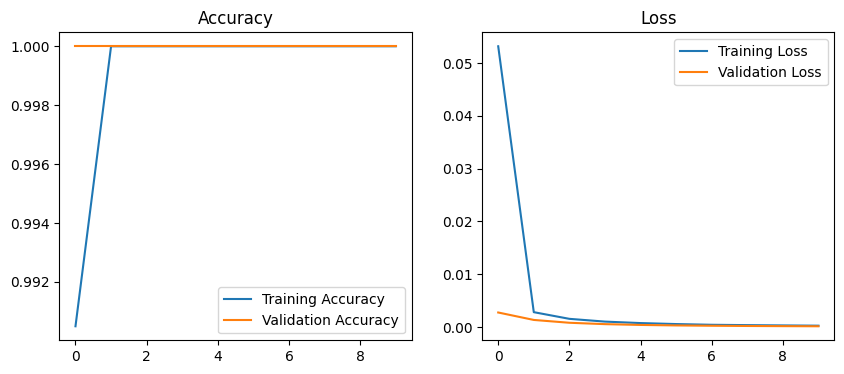

In [24]:
# Step 10: Plot training metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(); plt.title("Loss")

plt.show()


In [26]:
# Step 11: Save the trained model to Drive
model_save_path = os.path.join(project_path, "malaria_model.h5")
model.save(model_save_path)
print(" Model saved to:", model_save_path)


 Model saved to: /content/drive/MyDrive/Malaria_Cell_Classifier/malaria_model.h5


In [31]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Define class labels
class_names = ['Parasitized', 'Uninfected']

# Define prediction function
def predict_malaria(img):
    img = img.resize((64, 64))  # resize to match model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # normalization
    prediction = model.predict(img_array)
    result = class_names[int(prediction[0][0] > 0.5)]
    confidence = float(prediction[0][0] if result == 'Uninfected' else 1 - prediction[0][0])
    return {result: confidence}

# Create Gradio interface
interface = gr.Interface(
    fn=predict_malaria,
    inputs=gr.Image(type="pil", label="Upload Cell Image"),
    outputs=gr.Label(num_top_classes=2, label="Prediction"),
    title="🩸 Malaria Cell Classifier",
    description="Upload a cell image to detect whether it is Parasitized or Uninfected.",
    theme=gr.themes.Soft(primary_hue="purple", secondary_hue="blue"),
)

# Launch the app
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a5f23e45da593de1cd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
